## Environment Setup

In [1]:
#!pip install transformers datasets seqeval

## Imports

In [2]:
import csv
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import shutil
import torch

from collections import Counter, defaultdict
from datasets import load_dataset, ClassLabel
from seqeval.metrics import classification_report, f1_score
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from torch.nn.functional import cross_entropy
from torch.optim import AdamW
from torch.utils.data import DataLoader, SubsetRandomSampler
from transformers import (
    AutoTokenizer, AutoModelForTokenClassification, AutoConfig,
    DataCollatorForTokenClassification,
    get_scheduler
)

## Part 1 : Data Processing
The dataset on which we're going to apply bert (it's the `ner_df1.csv` file) .

As you can see, the dataset provides NER tags. Each line contains a token,and it's NER tag. The first token of each sentence also contains a Sentence Number that follows the pattern "Sentence: \d+".

In this section we process this format into a JSON format that our HuggingFace `load_dataset` function can consume easily. Essentially, we convert it into a JSON structure as follows and write it out into JSON-L files. The JSON structure maps 1:1 to the Dataset format as we will see later.

Example :
```
{
  "tokens": ["Barack", "Obama", ..., "United", "States", "."],
  "ner_tags": ["B-PER", "I-PER", ..., "B-GPE", "I-GPE", "O"]
}
```

We also split the dataset into three JSON-L files for training, validation, and test using a random-number generation technique.

In [3]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
!ls /content/drive/MyDrive/

 BioWordVec_PubMed_MIMICIII_d200.vec.bin   mald.csv	     re_data.csv
'Colab Notebooks'			   MTR.csv	     relation2id.txt
 conception.png				   ner_data.csv      test1.json
 corpus					   ner_dataset.csv   train1.json
 dev_all.csv				   pre_test.txt      train_all.csv
 embeddings				   pre_train.txt     valid1.json


In [5]:
!head /content/drive/MyDrive/ner_data.csv

,File ID,Sentence #,Word,POS,Start,End,Tag
0,Myelodysplastic-Syndromes,1,When,ADV,0,4,O
1,Myelodysplastic-Syndromes,1,the,DET,5,8,O
2,Myelodysplastic-Syndromes,1,cause,NOUN,9,14,O
3,Myelodysplastic-Syndromes,1,of,ADP,15,17,O
4,Myelodysplastic-Syndromes,1,MDS,PROPN,18,21,B-RAREDISEASE
5,Myelodysplastic-Syndromes,1,is,AUX,22,24,O
6,Myelodysplastic-Syndromes,1,unknown,ADJ,25,32,O
7,Myelodysplastic-Syndromes,1,it,PRON,33,35,O
8,Myelodysplastic-Syndromes,1,is,AUX,36,38,O


In [6]:
GS_DATA_DIR = "/content/drive/MyDrive/"
DATA_DIR = "data"

NER_FILEPATH = os.path.join(GS_DATA_DIR, "ner_data.csv")

OUTPUT_FILEPATHS = [
  os.path.join(DATA_DIR, "train.jsonl"),
  os.path.join(DATA_DIR, "valid.jsonl"),
  os.path.join(DATA_DIR, "test.jsonl")
]
BASE_MODEL_NAME='alvaroalon2/biobert_diseases_ner'
MODEL_DIR = os.path.join(DATA_DIR, "{:s}-ner".format(BASE_MODEL_NAME))

In [7]:
def write_output(tokens, labels, output_files, num_writter):
  assert(len(tokens) == len(labels))
  rec = json.dumps({ "tokens": tokens, "ner_tags": labels })
  dice = random.random()
  if dice <= 0.75:
    output_files[0].write("{:s}\n".format(rec))
    num_written[0] += 1
  elif dice <= 0.85:
    output_files[1].write("{:s}\n".format(rec))
    num_written[1] += 1
  else:
    output_files[2].write("{:s}\n".format(rec))
    num_written[2] += 1


os.makedirs(DATA_DIR, exist_ok=True)
output_files = [open(filepath, "w") for filepath in OUTPUT_FILEPATHS]
num_written = [0, 0, 0]
tokens, labels = [], []
with open(NER_FILEPATH, "r", encoding="latin-1") as fner:
  csv_reader = csv.reader(fner)
  next(csv_reader)  # skip header
  s=2
  for row in csv_reader:
    if row[2]==str(s) and len(tokens) > 0:
      # write out current sentence to train / valid / test
      write_output(tokens, labels, output_files, num_written)
      tokens, labels = [], []
      s=s+1
    # accumulate tokens and labels
    tokens.append(row[3])
    labels.append(row[-1])
    # if num_written[0] > 1000:
    #   break

if len(tokens) > 0:
  write_output(tokens, labels, output_files, num_written)

[output_file.close() for output_file in output_files]
print(num_written)

[5492, 727, 1135]


## Dataset

We now want to convert our three JSON-L files `train.jsonl`, `validation.jsonl` and `test.jsonl` files into our raw dataset.

First we produce a mapping of name to file path, and call `load_dataset` on it with `format="json"`.

This creates a DatasetDict object with three Datasets identified by the names specified in the `data_files` mapping.

In [8]:
data_files = {
    "train": OUTPUT_FILEPATHS[0],
    "validation": OUTPUT_FILEPATHS[1],
    "test": OUTPUT_FILEPATHS[2]
}
dataset = load_dataset("json", data_files=data_files)
dataset

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset json downloaded and prepared to /root/.cache/huggingface/datasets/json/default-8ca614e26aa7a700/0.0.0/0f7e3662623656454fcd2b650f34e886a7db4b9104504885bd462096cc7a9f51. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 5492
    })
    validation: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 727
    })
    test: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 1135
    })
})

In [9]:
# dataset["train"][0]

## Distribution of Entity Types across splits

We want to make sure that the validation and test sets look roughly similar to the training set in terms of distribution of data across the different classes. We can verify that by using the following code, which computes the distribution across the different classes across different splits.

We see that the distribution of tags are roughly similar across splits, so validation and test sets should provide a good measure of the NER's generalization capabilities.

In [10]:
tag_freqs_by_split = defaultdict(Counter)
for split, data in dataset.items():
  for ner_tags in data["ner_tags"]:
    for tag in ner_tags:
      if tag.startswith("B-"):
        tag = tag.replace("B-", "")
        tag_freqs_by_split[split][tag] += 1
pd.DataFrame.from_dict(tag_freqs_by_split, orient="index")

,RAREDISEASE,DISEASE,SIGN,SYMPTOM
train,3074,1308,2437,236
validation,367,192,391,34
test,627,314,491,45


## Tokenization and Label Alignment

We now have to deal with the subword tokenization alignment problem that come with using Transformers.

Transformers use subword tokenization to split long words into their more common subwords, for example "Washington" could become "Wash", "##ing", and "##ton". Common subwords would be reused across different words. This helps to keep the vocabulary size down, or conversely, helps to cover a larger input vocabulary using the same size of tokenizer vocabulary.

However, our input sequence of `tokens` is space separated (with some additional heuristics around punctuation that is already taken care of in the provided input) and our `ner_tags` are aligned with this space-separated token sequence.

Since Transformers expect their input to be subword tokenized, the corresponding labels need to be aligned with the subword tokens as well. So for our "Washington" example, the corresponding labels will change from a single "B-LOC" to "B-LOC", "IGN", and "IGN", i.e. the trailing subwords would be ignored.

To do the mapping, we need the Tokenizer's `word_ids()` function, that maps the original token ids onto the subword tokenized sequence, which is only available from the "faster" Rust-based Tokenizer implementations. Fortunately, the AutoTokenizer will choose version of the Tokenizer for us automatically. We will use this to construct an "aligned" version of the `ner_tags`.


In [11]:
tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL_NAME)

In [12]:
tokens = tokenizer(dataset["train"][0]["tokens"], is_split_into_words=True).tokens()
tokens

['[CLS]',
 'When',
 'the',
 'cause',
 'of',
 'MD',
 '##S',
 'is',
 'unknown',
 'it',
 'is',
 'called',
 'id',
 '##io',
 '##pathic',
 'MD',
 '##S',
 '.',
 '[SEP]']

In [13]:
input = tokenizer(dataset["train"][0]["tokens"], is_split_into_words=True)
word_ids = input.word_ids()
pd.DataFrame([tokens, word_ids], index=["tokens", "word_ids"])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
tokens,[CLS],When,the,cause,of,MD,##S,is,unknown,it,is,called,id,##io,##pathic,MD,##S,.,[SEP]
word_ids,None,0,1,2,3,4,4,5,6,7,8,9,10,10,10,11,11,12,None


### Class Label Mappings

In the encoded dataset, since the input will be converted to arrays of floats, we also want to do the same thing with the labels.

For this we construct a ClassLabel object and use its `int2str` and `str2int` methods to construct lookup tables from label name to label id and vice versa.

In [14]:
entity_types = set()
for ner_tags in dataset["train"]["ner_tags"]:
  for ner_tag in ner_tags:
    if ner_tag.startswith("B-"):
      entity_types.add(ner_tag.replace("B-", ""))
entity_types = sorted(list(entity_types))

tag_names = []
for entity_type in entity_types:
  tag_names.append("B-{:s}".format(entity_type))
  tag_names.append("I-{:s}".format(entity_type))
tag_names.append("O")

tags = ClassLabel(names=tag_names)
label2id = {name: tags.str2int(name) for name in tag_names}
id2label = {id: tags.int2str(id) for id in range(len(tag_names))}

# label2id, id2label

In [15]:
id2label

{0: 'B-DISEASE',
 1: 'I-DISEASE',
 2: 'B-RAREDISEASE',
 3: 'I-RAREDISEASE',
 4: 'B-SIGN',
 5: 'I-SIGN',
 6: 'B-SYMPTOM',
 7: 'I-SYMPTOM',
 8: 'O'}

We now define the `tokenize_and_align_labels` which takes a batch of records from the input raw dataset, i.e. the input `examples` object is a list of dictionaries with keys `{"tokens", "ner_tags"}`.

The output of this function is a list of tokenized input objects, which are dictionaries with keys `{"input_ids", "token_type_ids", "attention_masks", "labels"}`. The first three keys are from the output of the tokenizer, and the last one is a numeric representation of the input `ner_tags` aligned to the subworded tokens.

We convert the raw dataset to the encoded one by calling `map` on the raw dataset with `tokenize_and_align_labels` as the function. The `map` call is applied batch-wise, and the original keys `ner_tags` and `tokens` are removed from the encoded dataset.

In [16]:
def tokenize_and_align_labels(examples):
  tokenized_inputs = tokenizer(examples["tokens"], 
                               truncation=True, 
                               is_split_into_words=True)
  aligned_batch_labels = []
  for idx, labels in enumerate(examples["ner_tags"]):
    word_ids = tokenized_inputs.word_ids(batch_index=idx)
    prev_word_id = None
    aligned_labels = []
    for word_id in word_ids:
      if word_id is None or word_id == prev_word_id:
        aligned_labels.append(-100)   # IGNore tag
      else:
        aligned_labels.append(label2id[labels[word_id]])
      prev_word_id = word_id
    aligned_batch_labels.append(aligned_labels)
  tokenized_inputs["labels"] = aligned_batch_labels
  return tokenized_inputs


tokens = dataset["train"][0]["tokens"]
ner_tags = dataset["train"][0]["ner_tags"]
aligned_labels = tokenize_and_align_labels(dataset["train"][0:1])["labels"][0]
len(tokens), len(ner_tags), len(aligned_labels)

(13, 13, 19)

In [17]:
encoded_dataset = dataset.map(tokenize_and_align_labels,
                                      batched=True,
                                      remove_columns=["ner_tags", "tokens"])
encoded_dataset

  0%|          | 0/6 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 5492
    })
    validation: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 727
    })
    test: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 1135
    })
})

## DataLoader

PyTorch models are trained using outputs from a DataLoader, which is created by wrapping the Dataset. We will use the encoded Dataset splits to create the corresponding DataLoaders for training, validation and test.

We define a `DataCollatorForTokenClassification` which will take care of padding each batch of the encoded dataset. Even though we are feeding it arrays of numbers, the number of tokens for each sentence in the batch can be different, and hence results in a "jagged" array. By setting `padding="longest"` we ensure that each batch results in non-jagged matrices padded with padding characters.

The use of the `sampler` parameter is to help during testing. Since the training run time can be quite long, we want to be able to iterate rapidly during development by training on a small sample of the data (1000 training examples in our case). To switch between "development" and "run" modes, comment the `shuffle` and uncomment the `sampler` parameter respectively.

In [18]:
BATCH_SIZE = 8

In [19]:
collate_fn = DataCollatorForTokenClassification(tokenizer, padding="longest", return_tensors="pt")

train_dl = DataLoader(encoded_dataset["train"], 
                      shuffle=True, 
                      batch_size=BATCH_SIZE, 
                      collate_fn=collate_fn)
valid_dl = DataLoader(encoded_dataset["validation"], 
                      shuffle=False,                   
                      batch_size=BATCH_SIZE, 
                      collate_fn=collate_fn)
test_dl = DataLoader(encoded_dataset["test"],
                     shuffle=False,                  
                     batch_size=BATCH_SIZE, 
                     collate_fn=collate_fn)

## Model

This step discovers if we have a GPU available. If we do, the model is instantiated and assigned to the GPU, otherwise it continues to process on the CPU.

In general, while in development mode, it is preferable to work with the CPU (i.e do not set the GPU to the notebook via Runtime :: Change Runtime Type). Once you are satisfied that your model is working, then enable GPU. This saves on GPU utilization across Colab (and since access to GPU is based on availability, also potentially increases the chance that you will have access to the GPU when you need it).

In the `AutoModelForTokenClassification.from_pretrained` call, we instantiate a `BertForTokenClassification` object from HuggingFace. This is a model with a BERT encoder and a head consisting of a `torch.nn.Dropout` and a `torch.nn.Linear` layer for classifying the output of the pre-trained BERT encoder into one of `num_labels` possible NER tags.

__NOTE:__ remember to set the `num_labels` parameter, otherwise the model will default to a binary classifier, and you will see a hard to understand error when you do the training.

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [21]:
model = AutoModelForTokenClassification.from_pretrained(BASE_MODEL_NAME,
                                                        num_labels=len(tag_names),
                                                        id2label=id2label,
                                                        label2id=label2id,
                                                        output_attentions = True,
                                                        output_hidden_states = True,
                                                        ignore_mismatched_sizes=True)
model = model.to(device)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at alvaroalon2/biobert_diseases_ner and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([3, 768]) in the checkpoint and torch.Size([9, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([9]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [22]:
 id2label

{0: 'B-DISEASE',
 1: 'I-DISEASE',
 2: 'B-RAREDISEASE',
 3: 'I-RAREDISEASE',
 4: 'B-SIGN',
 5: 'I-SIGN',
 6: 'B-SYMPTOM',
 7: 'I-SYMPTOM',
 8: 'O'}

## Training Loop

In this section we define all the functions and objects that will be needed to do the training. The training loop is constructed as follows:

```
for epoch in num_epochs:
    do_train()
    do_eval()
```

The `align_predictions` function is the reverse of `tokenize_and_align_labels` function. It will remove the labels and predictions corresponding to the IGN tags or "##word" tokens and align the labels and predictions.

We also want to compute the F1-score since it makes more sense to compute this for NER tasks. In the `do_eval` function, we will just call the `compute_f1_score` function so its cleaner and more generic.

In [23]:
LEARNING_RATE = 3e-5
WEIGHT_DECAY = 2e-3
NUM_EPOCHS = 3

In [24]:
optimizer = AdamW(model.parameters(),
                  lr=LEARNING_RATE,
                  weight_decay=WEIGHT_DECAY)

num_training_steps = NUM_EPOCHS * len(train_dl)
lr_scheduler = get_scheduler("linear",
                             optimizer=optimizer,
                             num_warmup_steps=0,
                             num_training_steps=num_training_steps)

In [25]:
def align_predictions(labels_cpu, preds_cpu):
  # remove -100 labels from score computation
  batch_size, seq_len = preds_cpu.shape
  labels_list, preds_list = [], []
  for bid in range(batch_size):
    example_labels, example_preds = [], []
    for sid in range(seq_len):
      # ignore label -100
      if labels_cpu[bid, sid] != -100:
        example_labels.append(id2label[labels_cpu[bid, sid]])
        example_preds.append(id2label[preds_cpu[bid, sid]])
    labels_list.append(example_labels)
    preds_list.append(example_preds)
  return labels_list, preds_list


def compute_f1_score(labels, logits):
  # convert logits to predictions and move to CPU
  preds_cpu = torch.argmax(logits, dim=-1).cpu().numpy()
  labels_cpu = labels.cpu().numpy()
  labels_list, preds_list = align_predictions(labels_cpu, preds_cpu)
  # seqeval.metrics.f1_score takes list of list of tags
  return f1_score(labels_list, preds_list)


# for batch in train_dl:
#   batch = {k: v.to(device) for k, v in batch.items()}
#   outputs = model(**batch)
#   break
# logits = outputs.logits
# labels = batch["labels"]
# print("labels.shape:", labels.size(), "logits.shape:", logits.size())
# score = compute_f1_score(labels, logits)
# print("f1-score:", score)

In [26]:
def do_train(model, train_dl):
  train_loss = 0
  model.train()
  for bid, batch in enumerate(train_dl):
    batch = {k: v.to(device) for k, v in batch.items()}
    outputs = model(**batch)
    loss = outputs.loss
    train_loss += loss.detach().cpu().numpy()
    loss.backward()

    optimizer.step()
    lr_scheduler.step()
    optimizer.zero_grad()

  return train_loss


def do_eval(model, eval_dl):
  model.eval()
  eval_loss, eval_score, num_batches = 0, 0, 0
  for bid, batch in enumerate(eval_dl):
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
      outputs = model(**batch)

    loss = outputs.loss

    eval_loss += loss.detach().cpu().numpy()
    eval_score += compute_f1_score(batch["labels"], outputs.logits)
    num_batches += 1

  eval_score /= num_batches

  return eval_loss, eval_score


def save_checkpoint(model, model_dir, epoch):
  model.save_pretrained(os.path.join(MODEL_DIR, "ckpt-{:d}".format(epoch)))


def save_training_history(history, model_dir, epoch):
  fhist = open(os.path.join(MODEL_DIR, "history.tsv"), "w")
  for epoch, train_loss, eval_loss, eval_score in history:
    fhist.write("{:d}\t{:.5f}\t{:.5f}\t{:.5f}\n".format(
        epoch, train_loss, eval_loss, eval_score))
  fhist.close()

## Training / Fine-tuning

In [27]:
import gc
torch.cuda.empty_cache()
gc.collect()

129

In [28]:
if os.path.exists(MODEL_DIR):
  shutil.rmtree(MODEL_DIR)
  os.makedirs(MODEL_DIR)

history = []

for epoch in range(NUM_EPOCHS):
  train_loss = do_train(model, train_dl)
  eval_loss, eval_score = do_eval(model, valid_dl)
  history.append((epoch + 1, train_loss, eval_loss, eval_score))
  print("EPOCH {:d}, train loss: {:.3f}, val loss: {:.3f}, f1-score: {:.5f}".format(
      epoch + 1, train_loss, eval_loss, eval_score))
  save_checkpoint(model, MODEL_DIR, epoch + 1)
  save_training_history(history, MODEL_DIR, epoch + 1)

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


EPOCH 1, train loss: 171.784, val loss: 16.947, f1-score: 0.94776
EPOCH 2, train loss: 83.623, val loss: 16.629, f1-score: 0.95316
EPOCH 3, train loss: 51.165, val loss: 17.198, f1-score: 0.95344


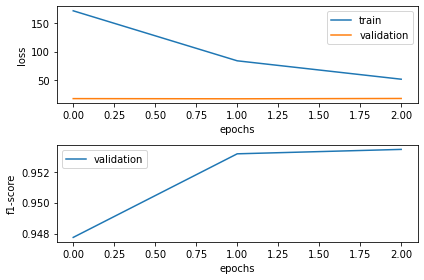

In [29]:
plt.subplot(2, 1, 1)
plt.plot([train_loss for _, train_loss, _, _ in history], label="train")
plt.plot([eval_loss for _, _, eval_loss, _ in history], label="validation")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(loc="best")

plt.subplot(2, 1, 2)
plt.plot([eval_score for _, _, _, eval_score in history], label="validation")
plt.xlabel("epochs")
plt.ylabel("f1-score")
plt.legend(loc="best")

plt.tight_layout()
_ = plt.show()

## Evaluation

We evaluate our trained model against the test split in two ways. 

1. Compute the precision, recall, and f1-score for each NER tag and produce the classification report. We use the `seqeval.classification_report` function for this, since it takes list of lists for labels and prediction, unlike the `sklearn.metrics.classification_report` which takes a pair of lists.
2. Confusion matrix -- a more graphical and easier to understand report of model performance. We can see for which NER tags the model is doing well, and for which ones it is making mistakes.



In [30]:
def get_label_and_predicted_tags(batch):
  batch = {k: v.to(device) for k, v in batch.items()}
  with torch.no_grad():
    outputs = model(**batch)
  preds_cpu = torch.argmax(outputs.logits, dim=-1).cpu().numpy()
  labels_cpu = batch["labels"].cpu().numpy()
  labels_list, preds_list = align_predictions(labels_cpu, preds_cpu)  
  return labels_list, preds_list


id2label[-100] = "IGN"
test_labels_list, test_preds_list = [], []
for batch in test_dl:
  labels_list, preds_list = get_label_and_predicted_tags(batch)
  for labels, preds in zip(labels_list, preds_list):
    test_labels_list.append(labels)
    test_preds_list.append(preds)

print(classification_report(test_labels_list, test_preds_list))

              precision    recall  f1-score   support

     DISEASE       0.63      0.69      0.66       321
       Other       0.97      0.98      0.98     20852
 RAREDISEASE       0.90      0.89      0.89       645
        SIGN       0.54      0.55      0.55       615
     SYMPTOM       0.67      0.70      0.69        47

   micro avg       0.95      0.96      0.96     22480
   macro avg       0.74      0.76      0.75     22480
weighted avg       0.95      0.96      0.96     22480



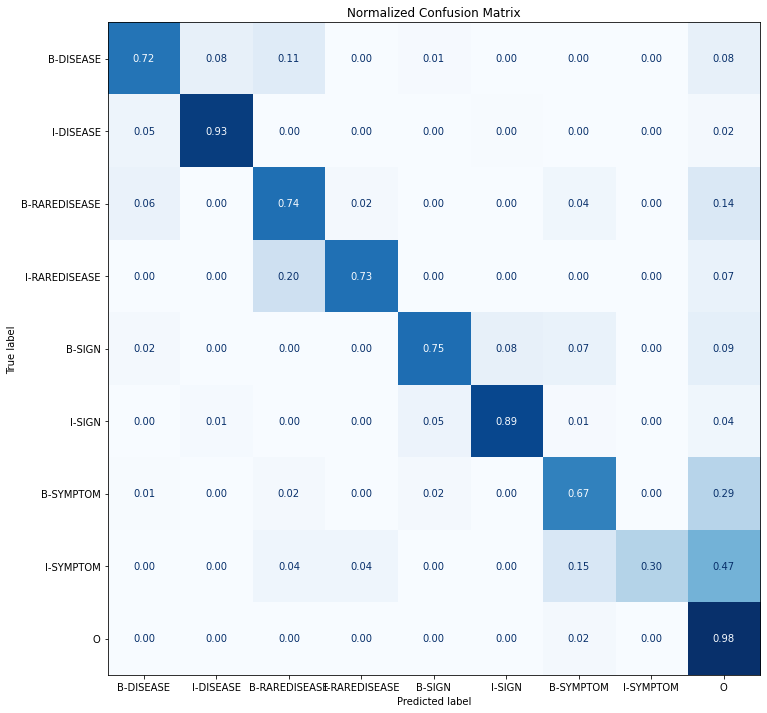

In [31]:
def plot_confusion_matrix(ytrue, ypreds, labels):
  cm = confusion_matrix(ytrue, ypreds, normalize="true")
  fig, ax = plt.subplots(figsize=(12, 12))
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
  disp.plot(cmap="Blues", values_format="0.2f", ax=ax, colorbar=False)
  plt.title("Normalized Confusion Matrix")
  _ = plt.show()

flat_test_labels, flat_test_preds = [], []
for test_labels, test_preds in zip(test_labels_list, test_preds_list):
  flat_test_labels.extend(test_labels)
  flat_test_preds.extend(test_preds)
plot_confusion_matrix(flat_test_labels, flat_test_preds, tag_names)

#### **Saving the model for future use**

Finally, let's save the vocabulary (.txt) file, model weights (.bin) and the model's configuration (.json) to a directory, so that both the tokenizer and model can be re-loaded using the `from_pretrained()` class method.


In [32]:
import os

directory = "/drive/My Drive/bestmodel"

if not os.path.exists(directory):
    os.makedirs(directory)

# save vocabulary of the tokenizer
tokenizer.save_vocabulary(directory)
# save the model weights and its configuration file
model.save_pretrained(directory)
print('All files saved')

All files saved
